<h1>ASSIGNMENT 5 : Logistic Regression on Amazon Fine Food Reviews</h1>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

<strong> OBJECTIVES :</strong>
    - Featurization/ Vectorization : Bow, tf-idf, avg w2v, tf-idf w2v
    - Train & Test Split : Time based slicing (70:30)
    - Cross validation : k-fold cv to find optimal c for each Vectorization
    - Test accuracy,f1 score,precsion,confusion matrix applied on all vectorization
    - Optimal C Techniques : GridSearchCV and RandomSearchCV
    - Regularisation : L1 and L2

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [39]:
# Loading Pre-Processed data( Reviews ) from database
conn = sqlite3.connect('final_database.sqlite')
data = pd.read_sql_query('''SELECT * FROM Reviews''',conn)

In [40]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [41]:
data.shape

(364171, 12)

In [42]:
# Sorting data in ascending order wrt time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time")

In [43]:
data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [44]:
data["Score"].value_counts()

positive    307061
negetive     57110
Name: Score, dtype: int64

In [45]:

def Partition(x):
    if x == "positive":
        return 1
    else:
        return 0
    
actual_score = data['Score']
pone = actual_score.map(Partition)
data['Score'] = pone

data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [46]:
data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [47]:
X = data["CleanText"]
y = data["Score"]

In [48]:
#Splitting sampe data in train and test dataset in  70:30
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
#encoded_labels =data["Score"].map(lambda x: 1 if x == 'positive' else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 0)
print(X_train.shape, X_test.shape)

(254919,) (109252,)


In [49]:
#Sampling 100k data pts in 70:30 train test

X_tr = X_train.iloc[1:70001]
y_tr = y_train.iloc[1:70001]
Xt = X_test.iloc[1:30001]
yt = y_test.iloc[1:30001]

print(X_tr.shape,Xt.shape)

(70000,) (30000,)


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform  
from sklearn.model_selection import TimeSeriesSplit

# function to calculate hyperparameter using GridSearchCV
def LRG(X_train,y_train,X_test, y_test,R):
    tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0, 10,10**2, 10**3]}]
    tscv = TimeSeriesSplit(n_splits=3)
    
    model = GridSearchCV(LogisticRegression(penalty = R, fit_intercept = False), tuned_parameters, scoring = 'f1_weighted', cv=tscv)
    model.fit(X_train, y_train)
   
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in model.grid_scores_:
        if (R == 'l1'):
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
    
    print(model.best_estimator_)
    print("\nF1 score is :")
    print(model.score(X_test, y_test))
    
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    print("\nConfusion Matrix :")
    print(cm)
    plt.figure()
    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("CONFUSION MATRIX ")
    
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    print('\n****Test accuracy  is %d%%' % (acc))
    
    prs = precision_score(yt, pred, average='weighted')
    print("\nprecision score is "+str(prs))
    
    rcs = recall_score(yt, pred, average='weighted')
    print("\nrecall score is "+str(rcs))

In [51]:
# function to calculate hyperparameter using RandomSearchCV
def LRR(X_train,y_train,X_test, y_test,R):
  
    par = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
    tscv = TimeSeriesSplit(n_splits=3)
    
    model = RandomizedSearchCV(LogisticRegression(penalty = R, fit_intercept = False), par, scoring = 'f1_weighted', cv=tscv)
    model.fit(X_train, y_train)

    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in model.grid_scores_:
        if (R == 'l1'):
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
    
    print(model.best_estimator_)
    print("\nF1 score is :")
    print(model.score(X_test, y_test))
    
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    print("\nConfusion Matrix :")
    print(cm)
    plt.figure()
    heatmap = sns.heatmap(cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("CONFUSION MATRIX ")
    
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    print('\n****Test accuracy  is %d%%' % (acc))
    
    prs = precision_score(yt, pred, average='weighted')
    print("\nprecision score is "+str(prs))
    
    rcs = recall_score(yt, pred, average='weighted')
    print("\nrecall score is "+str(rcs))

In [52]:
#function to find top feaures
def show_most_informative_features(vectorizer,R, n=25):
   
    LR = LogisticRegression(penalty = 'l2',C=R)
    LR.fit(Xtr,y_tr)
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(LR.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegetive\t\t\t\t\t\tPositve")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t\t%s\t\t\t\t\t%s" % ( fn_1,  fn_2))


<h3>BoW</h3>

In [21]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
count_vect = CountVectorizer()
X_tr = count_vect.fit_transform(X_tr)
Xt = count_vect.transform(Xt)

In [23]:
print("the type of count vectorizer ",type(X_tr))
print("the shape of out text BOW vectorizer ",X_tr.get_shape())
print("the number of unique words ", X_tr.get_shape()[1])

print("the shape of out text BOW vectorizer ",Xt.get_shape())
print("the number of unique words ", Xt.get_shape()[1])

print("the shape of out text BOW vectorizer ",Xt.get_shape())
print("the number of unique words ", Xt.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 61998)
the number of unique words  61998
the shape of out text BOW vectorizer  (30000, 61998)
the number of unique words  61998
the shape of out text BOW vectorizer  (30000, 61998)
the number of unique words  61998


In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit_transform(X_tr)
scaler.transform(Xt)

<30000x61998 sparse matrix of type '<class 'numpy.float64'>'
	with 945853 stored elements in Compressed Sparse Row format>

Wall time: 0 ns


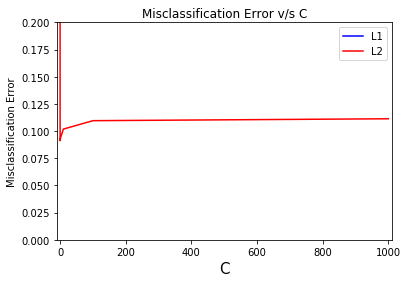

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.9146119269868495

Confusion Matrix :
[[ 3147  1604]
 [  872 24377]]

****Test accuracy  is 91%

precision score is 0.9136790065530339

recall score is 0.9174666666666667


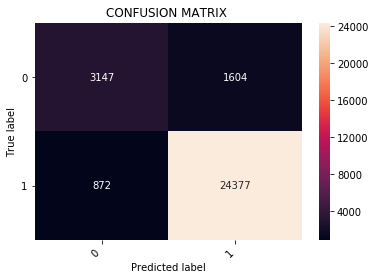

In [44]:
LRG(X_tr,y_tr,Xt, yt,'l2')

Wall time: 0 ns


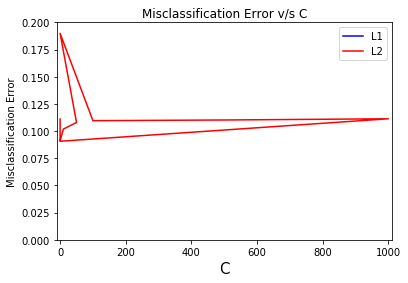

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.9146081545596565

Confusion Matrix :
[[ 3247  1504]
 [ 1000 24249]]

****Test accuracy  is 91%

precision score is 0.9135587360527304

recall score is 0.9165333333333333


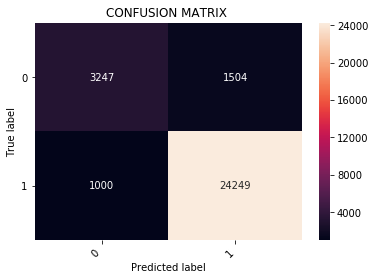

In [47]:
LRR(X_tr,y_tr,Xt, yt,'l2')

<strong>PERTURBATION TEST</strong>

In [48]:
clf = LogisticRegression(C= 0.1, penalty= 'l2')
clf.fit(X_tr,y_tr)
y_pred = clf.predict(Xt)
w = clf.coef_
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
print(w.size)

Accuracy on test set: 91.640%
F1-Score on test set: 0.952
61998


In [49]:
X_tr.data = X_tr.data + 0.001

In [50]:
clf = LogisticRegression(C= 0.1, penalty= 'l2')
clf.fit(X_tr,y_tr)
y_pred = clf.predict(Xt)
w1 = clf.coef_
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
W1 = np.count_nonzero(w)
print(W1)

Accuracy on test set: 91.640%
F1-Score on test set: 0.952
61998


In [51]:
weights_diff = ((abs(w - w1)/w) * 100)
print(weights_diff)

[[ 0.08239598 -0.01236611 -0.0877336  ...  0.05234205 -0.07895468
   0.11283657]]


In [52]:
print(weights_diff[np.where(weights_diff > 30)].size)

70


<strong>70 features have weight changes greater than 30% so they are multi-collinear</strong> 

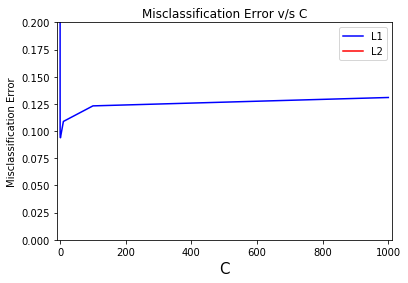

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.9111683615916113

Confusion Matrix :
[[ 3236  1515]
 [ 1101 24148]]

****Test accuracy  is 91%

precision score is 0.910111377613623

recall score is 0.9128


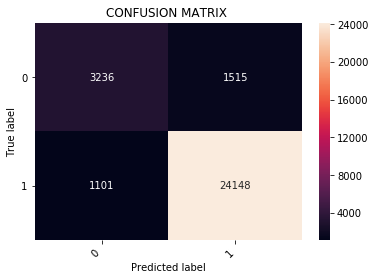

In [53]:
LRG(X_tr,y_tr,Xt, yt,'l1')

Wall time: 0 ns


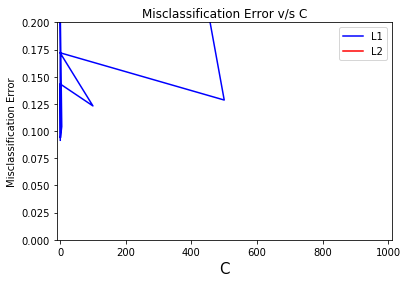

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.9142739245454398

Confusion Matrix :
[[ 3221  1530]
 [  978 24271]]

****Test accuracy  is 91%

precision score is 0.9132055286916322

recall score is 0.9164


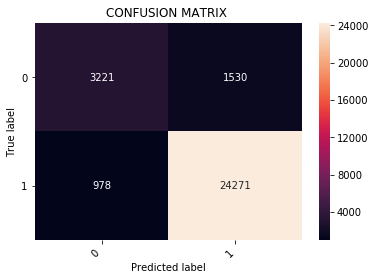

In [54]:
LRR(X_tr,y_tr,Xt, yt,'l1')

<strong>Sparsity Test</strong>

In [55]:
clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_tr,y_tr)
y_pred = clf.predict(Xt)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.417%
F1-Score on test set: 0.950
Non Zero weights: 4459


In [56]:
clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_tr,y_tr)
y_pred = clf.predict(Xt)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.230%
F1-Score on test set: 0.949
Non Zero weights: 885


In [57]:
clf = LogisticRegression(C= 0.001, penalty= 'l1')
clf.fit(X_tr,y_tr)
y_pred = clf.predict(Xt)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.160%
F1-Score on test set: 0.914
Non Zero weights: 7


<Strong>We can see how drastically the sparsity increases from 4459 non-zero weights(C=1) to only 7 non-zero weights( C=0.001) when we use L1 Regularization</Strong>

In [60]:
show_most_informative_features(count_vect,0.1)

		Negetive						Positve
________________________________________________________________________________________________
		worst					delici
		terribl					excel
		aw					perfect
		disappoint					best
		unfortun					worri
		tasteless					great
		horribl					amaz
		stale					awesom
		disgust					smooth
		ruin					hook
		threw					fantast
		return					hesit
		weak					nice
		bland					favorit
		yuck					satisfi
		sorri					yum
		poor					complaint
		gross					addict
		unpleas					happi
		cancel					beat
		concept					love
		earth					wonder
		wast					pleasant
		sad					skeptic
		wors					glad


<h3>TF-IDF</h3>

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()
Xtr = tf_idf_vect.fit_transform(X_tr)
X_t = tf_idf_vect.transform(Xt)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit_transform(Xtr)
scaler.transform(X_t)

<30000x61998 sparse matrix of type '<class 'numpy.float64'>'
	with 945853 stored elements in Compressed Sparse Row format>

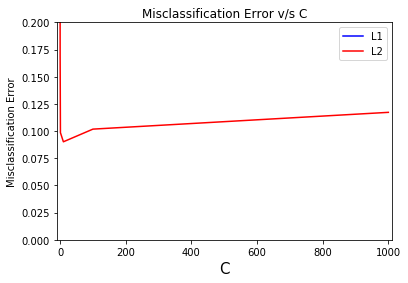

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.914292423930863

Confusion Matrix :
[[ 3131  1620]
 [  862 24387]]

****Test accuracy  is 91%

precision score is 0.9133860385582102

recall score is 0.9172666666666667


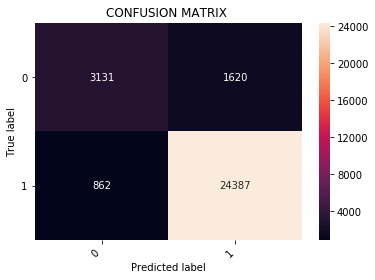

In [22]:
LRG(Xtr,y_tr,X_t, yt,'l2')

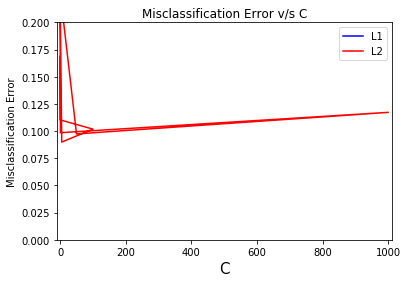

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.9149580557568119

Confusion Matrix :
[[ 3076  1675]
 [  769 24480]]

****Test accuracy  is 91%

precision score is 0.9144273803606703

recall score is 0.9185333333333333


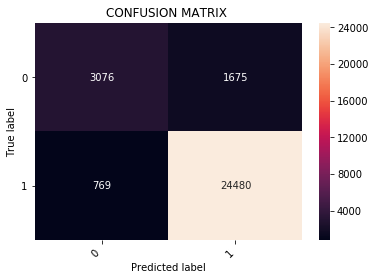

In [21]:
LRR(Xtr,y_tr,X_t, yt,'l2')

<strong>PERTURBATION TEST</strong>

In [30]:
clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(Xtr,y_tr)
y_pred = clf.predict(X_t)
w = clf.coef_
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
print(w.size)

Accuracy on test set: 91.887%
F1-Score on test set: 0.953
61998


In [31]:
Xtr.data = Xtr.data + 0.001

In [32]:
clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(Xtr,y_tr)
y_pred = clf.predict(X_t)
w1 = clf.coef_
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
print(w1.size)

Accuracy on test set: 91.887%
F1-Score on test set: 0.953
61998


In [33]:
weights_diff = ((abs(w - w1)/w) * 100)
print(weights_diff)

[[ 2.37102531 -2.39225092 -0.30196194 ...  1.63830717 -0.1087783
   3.83151365]]


In [34]:
print(weights_diff[np.where(weights_diff > 30)].size)

52


<strong>52 features have weight changes greater than 30% so they are multi-collinear</strong> 

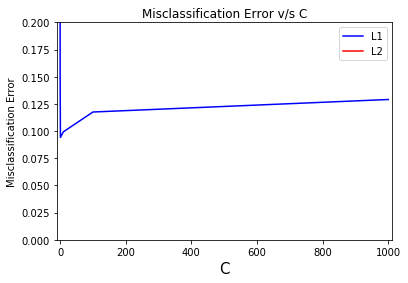

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.9132836424611497

Confusion Matrix :
[[ 3012  1739]
 [  741 24508]]

****Test accuracy  is 91%

precision score is 0.9129691839472377

recall score is 0.9173333333333333


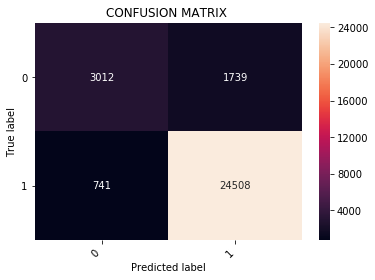

In [23]:
LRG(Xtr,y_tr,X_t, yt,'l1')

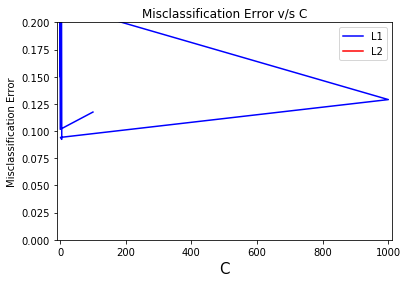

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.9132812319767186

Confusion Matrix :
[[ 3185  1566]
 [  965 24284]]

****Test accuracy  is 91%

precision score is 0.9121886046778993

recall score is 0.9156333333333333


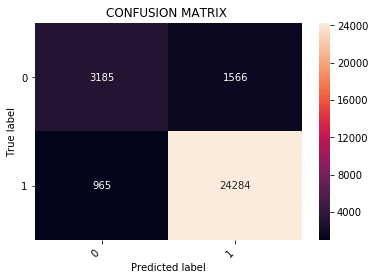

In [24]:
LRR(Xtr,y_tr,X_t, yt,'l1')

<strong>Sparsity Test</strong>

In [35]:
clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(Xtr,y_tr)
y_pred = clf.predict(X_t)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.683%
F1-Score on test set: 0.952
Non Zero weights: 1381


In [36]:
clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(Xtr,y_tr)
y_pred = clf.predict(X_t)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.040%
F1-Score on test set: 0.938
Non Zero weights: 211


In [37]:
clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(Xtr,y_tr)
y_pred = clf.predict(X_t)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(yt, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(yt, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.167%
F1-Score on test set: 0.914
Non Zero weights: 6


<Strong>We can see how drastically the sparsity increases from 1381 non-zero weights(C=1) to only 6 non-zero weights( C=0.001) when we use L1 Regularization</Strong>

In [27]:
show_most_informative_features(tf_idf_vect,10)

		Negetive						Positve
________________________________________________________________________________________________
		worst					great
		terribl					best
		disappoint					delici
		aw					perfect
		unfortun					love
		tasteless					worri
		horribl					excel
		return					amaz
		disgust					hook
		stale					awesom
		yuck					nice
		threw					good
		mediocr					smooth
		wast					fantast
		bland					favorit
		ruin					downsid
		unpleas					wonder
		hype					addict
		undrink					beat
		gross					yum
		weak					skeptic
		flavorless					thank
		poor					hesit
		unimpress					terrif
		concept					satisfi


<h3>word2vec</h3>

In [53]:
# Trainning Word2Vec model using own text corpus
i=0
list_of_sent=[]
for sent in X_tr.values: 
    list_of_sent.append(sent.split())

In [54]:
# Trainning Word2Vec model using own text corpus
i=0
list_of_sent_test=[]
for sent in Xt.values: 
    list_of_sent_test.append(sent.split())

In [55]:
# min_count = 5 considers only words that occured atleast 5 times
import warnings
warnings.filterwarnings("ignore")

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=3)

In [56]:
w2v_words = list(w2v_model.wv.vocab)

<h3>Average Word2Vec </h3>

In [25]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [26]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [27]:
X_tr = sent_vectors
Xt = sent_vectors_test

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X_tr)
scaler.transform(Xt)

array([[ 0.14527814,  0.71667813,  0.92415833, ..., -2.06075717,
        -0.11806437,  0.20336567],
       [ 1.44916332, -0.376135  ,  1.44927581, ..., -0.58768458,
        -0.68561667,  0.3747107 ],
       [ 0.25314813, -1.18300348,  1.19257742, ...,  0.39264422,
        -0.97221455, -0.80145811],
       ...,
       [ 0.91396587,  1.18562262, -2.73709179, ...,  0.07364151,
         2.95678782,  1.26077431],
       [ 0.00588495,  0.22087907,  0.34181672, ...,  0.34606831,
         1.48139917, -0.4372447 ],
       [-0.70706668, -0.53914363, -0.98243212, ..., -0.38148446,
        -0.84976337,  1.61473491]])

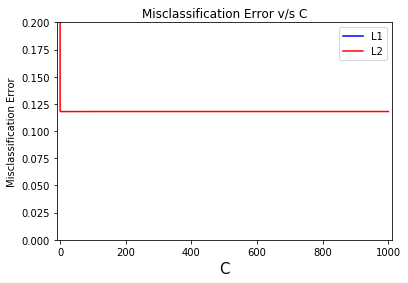

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.8783404505342997

Confusion Matrix :
[[ 2236  2515]
 [  828 24421]]

****Test accuracy  is 88%

precision score is 0.8786209290054264

recall score is 0.8885666666666666


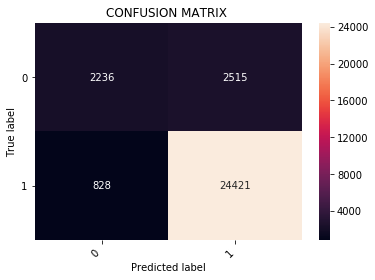

In [30]:
LRG(X_tr,y_tr,Xt, yt,'l2')

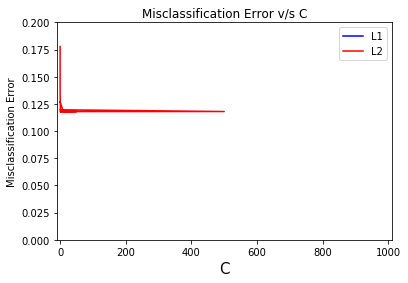

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.8782217859497474

Confusion Matrix :
[[ 2232  2519]
 [  826 24423]]

****Test accuracy  is 88%

precision score is 0.8785330809093622

recall score is 0.8885


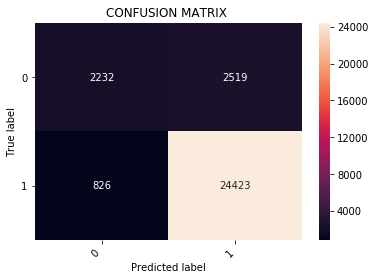

In [31]:
LRR(X_tr,y_tr,Xt, yt,'l2')

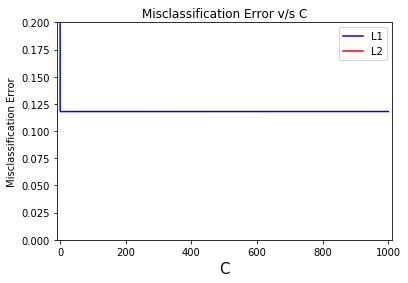

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.8783251754092781

Confusion Matrix :
[[ 2235  2516]
 [  827 24422]]

****Test accuracy  is 88%

precision score is 0.8786192869032124

recall score is 0.8885666666666666


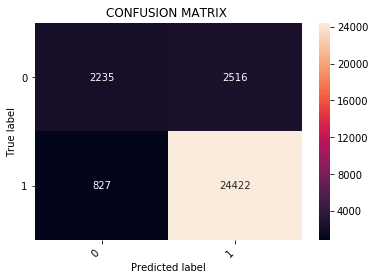

In [32]:
LRG(X_tr,y_tr,Xt, yt,'l1')

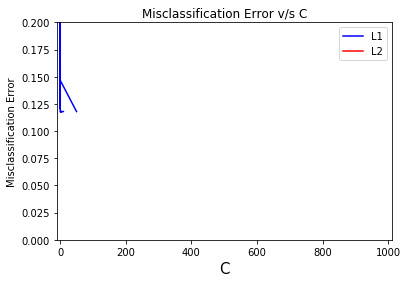

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.8781049063797227

Confusion Matrix :
[[ 2230  2521]
 [  827 24422]]

****Test accuracy  is 88%

precision score is 0.8784077288256478

recall score is 0.8884


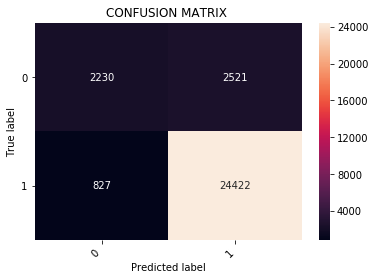

In [33]:
LRR(X_tr,y_tr,Xt, yt,'l1')

<h3>Tf-Idf Word2Vec </h3>

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [58]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
from tqdm import tqdm

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:44<00:00, 425.57it/s]


In [59]:
train = tfidf_sent_vectors

In [60]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
from tqdm import tqdm

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:11<00:00, 417.96it/s]


In [61]:
test = tfidf_sent_vectors_test

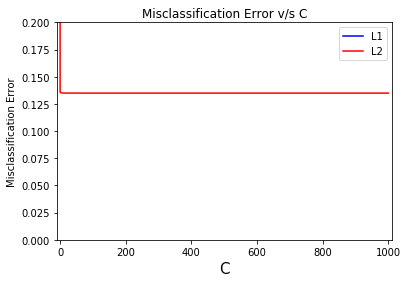

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.8607788960838729

Confusion Matrix :
[[ 1824  2927]
 [  785 24464]]

****Test accuracy  is 87%

precision score is 0.8624135211189612

recall score is 0.8762666666666666


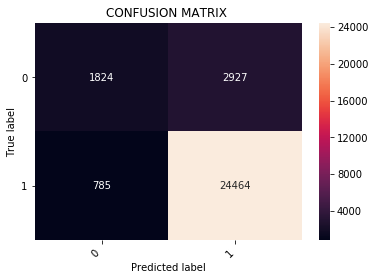

In [37]:
LRG(train,y_tr,test, yt,'l2')

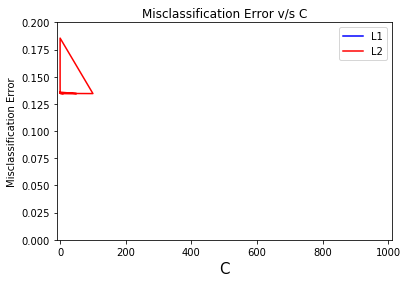

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.8616988560306267

Confusion Matrix :
[[ 1872  2879]
 [  833 24416]]

****Test accuracy  is 87%

precision score is 0.8624581410316099

recall score is 0.8762666666666666


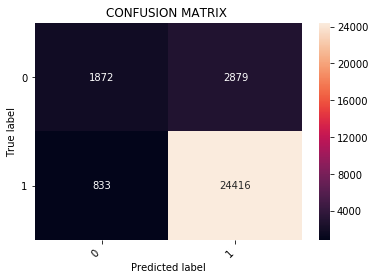

In [62]:
LRR(train,y_tr,test, yt,'l2')

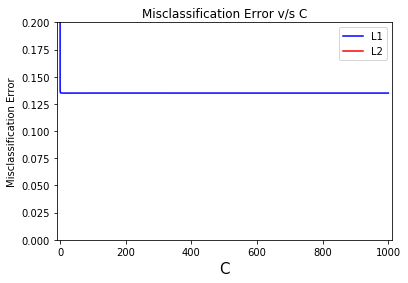

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.8608261223574757

Confusion Matrix :
[[ 1825  2926]
 [  785 24464]]

****Test accuracy  is 87%

precision score is 0.8624592218683161

recall score is 0.8763


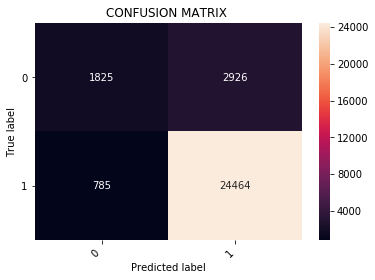

In [34]:
LRG(train,y_tr,test, yt,'l1')

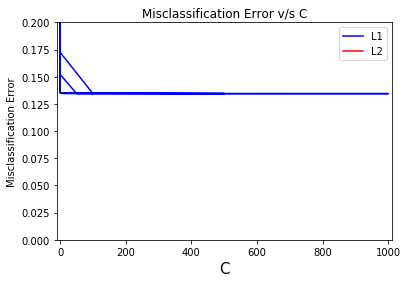

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

F1 score is :
0.8617455528229577

Confusion Matrix :
[[ 1873  2878]
 [  833 24416]]

****Test accuracy  is 87%

precision score is 0.8625037468362753

recall score is 0.8763


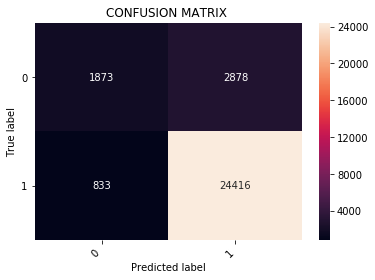

In [63]:
LRR(train,y_tr,test,yt,'l1')

<h2>Conclusion</h2>

Here we have considered 100k data points

In [64]:
table = {'Technique':['Bow with L2','Bow with L1', "TFIDF with L2","TFIDF with L1", "Avg_w2v with L2","Avg_w2v with L1", "tfidf_w2v with L2","tfidf_w2v with L1"],'C in GridSearch':[0.1,1,10,1,1,1,100,10],'F1 score GSV':[0.9515,0.9111,0.9142,0.9133,0.8783,0.8782,0.8607,0.8608],'C in RandomSearch':[0.5,0.5,5,5,1,1,100,1000],'F1 score RSV':[0.9146,0.9142,0.9150,0.9131,0.8782,0.8781,0.8616,0.8627],'Avg Accuracies':[91,91,91,91,88,88,87,87] }
df = pd.DataFrame(data=table)
df

,Technique,C in GridSearch,F1 score GSV,C in RandomSearch,F1 score RSV,Avg Accuracies
0,Bow with L2,0.1,0.9515,0.5,0.9146,91
1,Bow with L1,1.0,0.9111,0.5,0.9142,91
2,TFIDF with L2,10.0,0.9142,5.0,0.9150,91
3,TFIDF with L1,1.0,0.9133,5.0,0.9131,91
4,Avg_w2v with L2,1.0,0.8783,1.0,0.8782,88
5,Avg_w2v with L1,1.0,0.8782,1.0,0.8781,88
6,tfidf_w2v with L2,100.0,0.8607,100.0,0.8616,87
7,tfidf_w2v with L1,10.0,0.8608,1000.0,0.8627,87


    -Tf-idf performed Very well in Logistic Regression
    -Here Features are multi-collinear i.e. they are co-related
    -Sparsity increases as we increase lambda or decrease C in L1 Regularizer
    -tfidf w2v gave poorly result
    
    -Perburtation Results :
        -In BoW with noise of 0.001
        -70 features have weight changes greater than 30% so they are multi-collinear
        
        -In tfidf with noise of 0.001
        -52 features have weight changes greater than 30% so they are multi-collinear
        
    -Sparsity Results :
        -We can see how drastically the sparsity increases from 4459 non-zero weights(C=1) to only 7 non-zero weights(C=0.001) when we use L1 Regularization
        -For Tfidf, We can see how drastically the sparsity increases from 1381 non-zero weights(C=1) to only 6 non-zero                      weights(C=0.001) when we use L1 Regularization

In [278]:
print("End")

End
